# Урок 7

## Линейная регрессия. Однофакторный дисперсионный анализ.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Задача 1

#### Даны значения величины заработной платы заемщиков банка $(salary)$ и значения их поведенческого кредитного скоринга $(scoring)$:

$salary = [35, 45, 190, 200, 40, 70, 54, 150, 120, 110]$
$scoring = [401, 574, 874, 919, 459, 739, 653, 902, 746, 832]$

#### Возьмём в качестве признака значение $salary$, а в качестве целевой переменной - $scoring$.

1. Найдите коэффициенты линейной регрессии с помощью формул для парной регрессии, а затем с помощью метода наименьших квадратов.
2. Постройте scatter plot по данным и отметьте на нём прямую линейной регрессии, полученную в п. 1.
3. Посчитайте коэффициент детерминации, среднюю ошибку аппроксимации.
4. Оцените построенное уравнение регрессии с помощью F-критерия Фишера.
5. Постройте для коэффициентов регрессии доверительные интервалы с помощью t-статистики Стьюдента.

In [2]:
x1 = np.array([35, 45, 190, 200, 40, 70, 54, 150, 120, 110])
y1 = np.array([401, 574, 874, 919, 459, 739, 653, 902, 746, 832])

__1. Коэффициенты линейной регрессии с помощью формул для парной регрессии__

$b_1 = \frac{\overline{yx} - \overline{y} \cdot {\overline{x}}}{\overline{x^2} - (\overline{x})^2}, \: b_0 = \overline{y} - b_1 \cdot {\overline{x}}.$

In [3]:
b1 = (np.mean(x1 * y1) - np.mean(x1) * np.mean(y1)) / (np.mean(x1 ** 2) - np.mean(x1) ** 2)
b0 = np.mean(y1) - b1 * np.mean(x1)
print('b1=',np.round(b1,2),'b0=',np.round(b0,2))

b1= 2.62 b0= 444.18


Модель линейной регрессии имеет вид:
𝑦 = 444.18 + 2.62⋅𝑥

__Коэффициенты линейной регрессии с помощью метода наименьших квадратов__

$b = (X^\top X)^{-1} X^\top y.$

In [4]:
x2 = x1.reshape(-1, 1)

К матрице $X$ (массив $x1$) добавляем столбец из единиц:

In [5]:
ones = np.ones((x2.shape[0], 1))
x2 = np.hstack((ones, x2))

In [6]:
y2 = y1.reshape(-1, 1)

Запишем матрицу $X^\top X$ и посчитаем её определитель:

In [7]:
XTX = x2.T.dot(x2)

np.round(np.linalg.det(XTX),2)

349464.0

Определитель не нулевой, поэтому можно записать аналитическое решение:

In [8]:
XTX_inv = np.linalg.inv(XTX)

b = XTX_inv.dot(x2.T).dot(y2)

print(b)

[[444.17735732]
 [  2.62053888]]


Коэффициенты совпадают с найденными ранее коэффициентами с помощью формул для парной регрессии.

__2. Построим scatter plot по данным и отметим на нём прямую линейной регрессии, полученную в п. 1.__

Text(0, 0.5, 'scoring')

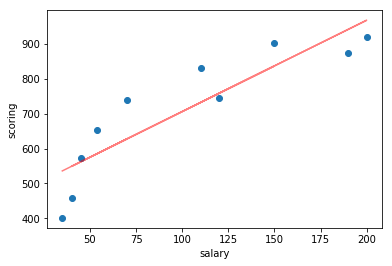

In [9]:
ox = x1
oy = b0 + b1 * ox

plt.scatter(x1, y1)
plt.plot(ox, oy, color='red', alpha=0.5)

plt.xlabel('salary')
plt.ylabel('scoring')

__3. Посчитаем коэффициент детерминации и среднюю ошибку аппроксимации.__

$R^2 = \dfrac{D_{model}}{D_y},\;  \overline{A} = \frac{1}{n} \displaystyle\sum_{i=1}^{n} \Bigl| {{\frac{y_i - z_i}{y_i}} \Bigr|}$

In [10]:
z1 = b0 + b1 * x1
R = z1.var() / y1.var()     
print('Kоэффициент детерминации:', np.round(R,3))

Kоэффициент детерминации: 0.788


Полученный коэффициент детерминации означает, что примерно $79 \%$ дисперсии переменной $y$ объясняется моделью. Оставшийся $21 \%$ обусловлен иными факторами, не учтенными моделью.

In [11]:
def mean_approximation_error(y_real, y_pred):
    return np.abs((y_real - y_pred) / y_real).mean()

print('Cредняя ошибка аппроксимации:', np.round(mean_approximation_error(y1, z1),4))

Cредняя ошибка аппроксимации: 0.1147


$\overline{A}$ превышает $8-10 \%$/. Это не очень хорошо, но можно осторожно допустить, что теоретические значения близки к результатам моделирования.

__4. Оценим построенное уравнение регрессии с помощью F-критерия Фишера.__

$T = \dfrac{R^2}{1 - R^2} \cdot \dfrac{n - k - 1}{k},$

In [12]:
k1, k2 = 1, 8
T = (R / (1 - R)) * (k2 / k1)

print('T =', np.round(T,3))

T = 29.672


Для уровня значимости $\alpha = 0.05$ посчитаем значение $F_{crit} = F(1, 8)$

In [13]:
alpha = 0.05

F_crit = stats.f.ppf(1 - alpha, k1, k2)
print('F_crit =', np.round(F_crit,3))

F_crit = 5.318


Уравнение регрессии статистически значимо т.к. T > F_crit

__5. Построим для коэффициентов регрессии доверительные интервалы с помощью t-статистики Стьюдента.__

In [14]:
def standard_error_slope(x, y, z):
    n = x.shape[0]
    
    upper = ((y - z) ** 2).sum() / (n - 2)
    lower = ((x - x.mean()) ** 2).sum()
    
    return np.sqrt(upper / lower)

s_slope = standard_error_slope(x1, y1, z1)
print('Коэффициент наклона:', np.round(s_slope,2))

Коэффициент наклона: 0.48


Чтобы оценить значимость параметра  $b_1$, рассмотрим нулевую гипотезу $H_0$, согласно которой реальное значение коэффициента $b_1$ равно 0 (т.е. что между значениями $x$ и $y$ нет корреляции). Найдем статистику $T$, которая имеет распределение Стьюдента со степенями свободы $n - 2$. Зададим уровень значимости $\alpha = 0.05$. В нашем случае $n = 10$, поэтому нас интересует $t_{1 - 0.05/2, \: 8} = 2.306$. Значение статистики $T$:

In [15]:
T = b1 / s_slope
print('T =', np.round(T,3))

T = 5.447


Доверительный интервал для параметра $b_1$:

$\left( \hat{b}_1 - t_{1 - \alpha/2, \: n - 2} \cdot S_{slope}, \: \hat{b}_1 + t_{1 - \alpha/2, \: n - 2} \cdot S_{slope} \right)$

In [16]:
t = 2.3060

print('Доверительный интервал для b1: ', np.round(b1 - t * s_slope,3), np.round( b1 + t * s_slope,3))

Доверительный интервал для b1:  1.511 3.73


Значение статистики $T$ попало в критическую область, значит, гипотеза о равенстве нулю параметра $b_1$ отвергается.

Проверим значимость коэффициента сдвига $b_0$ и построим доверительный интервал для него.

In [17]:
def standard_error_intercept(x, y, z):
    return standard_error_slope(x, y, z) * np.sqrt((x ** 2).mean())
s_intercept = standard_error_intercept(x1, y1, z1)
T = b0 / s_intercept
print('Доверительный интервал для b0: ', np.round(b0 - t * s_intercept,3), np.round(b0 + t * s_intercept,3))

Доверительный интервал для b0:  313.966 574.389


Значение статистики $T$ попало в критическую область, т.е параметр $b_0$ является статистически значимым.

### Задача 2

__Допустим, первые 5 клиентов из предыдущего задания проживают в Москве, а остальные - в Санкт-Петербурге. Влияет ли этот фактор на значение их кредитного скоринга?__

### Задача 3

__Посчитать коэффициенты линейной регрессии для т.н. Квартета Энскомба (см. урок 6).__

In [18]:
anscombe = pd.read_csv('C:/Users/Alex/Documents/anscombe_dataset.csv', encoding = 'cp1251')
anscombe.head(10)

,id,x1,y1,x2,y2,x3,y3,x4,y4
0,0,10.0,8.04,10.0,9.14,10.0,7.46,8.0,6.58
1,1,8.0,6.95,8.0,8.14,8.0,6.77,8.0,5.76
2,2,13.0,7.58,13.0,8.74,13.0,12.74,8.0,7.71
3,3,9.0,8.81,9.0,8.77,9.0,7.11,8.0,8.84
4,4,11.0,8.33,11.0,9.26,11.0,7.81,8.0,8.47
5,5,14.0,9.96,14.0,8.10,14.0,8.84,8.0,7.04
6,6,6.0,7.24,6.0,6.13,6.0,6.08,8.0,5.25
7,7,4.0,4.26,4.0,3.10,4.0,5.39,19.0,12.50
8,8,12.0,10.84,12.0,9.13,12.0,8.15,8.0,5.56
9,9,7.0,4.82,7.0,7.26,7.0,6.42,8.0,7.91


In [19]:
x1 = anscombe[['x1']].values.T
y1 = anscombe[['y1']].values.T
x2 = anscombe[['x2']].values.T
y2 = anscombe[['y2']].values.T
x3 = anscombe[['x3']].values.T
y3 = anscombe[['y3']].values.T
x4 = anscombe[['x4']].values.T
y4 = anscombe[['y4']].values.T

In [20]:
def _anscombe_(x, y):
    b1 = (np.mean(x1 * y1) - np.mean(x1) * np.mean(y1)) / (np.mean(x1 ** 2) - np.mean(x1) ** 2)
    b0 = np.mean(y1) - b1 * np.mean(x1)
    return b1, b0

In [21]:
_anscombe_(x1, y1)

(0.5000909090909076, 3.0000909090909245)

In [22]:
_anscombe_(x2, y2)

(0.5000909090909076, 3.0000909090909245)

In [23]:
_anscombe_(x3, y3)

(0.5000909090909076, 3.0000909090909245)

In [24]:
_anscombe_(x4, y4)

(0.5000909090909076, 3.0000909090909245)

Коэффициенты линейной регрессии одинаковы для всех пар признак-переменная.